In [1]:
import os
import cv2
import random
import glob as gb
import numpy as np
import pandas as pd 
import tensorflow as tf
import pydicom as dicom
from tensorflow import keras
from keras.models import Model 
from keras import backend as K
import matplotlib.pyplot as plt
from pydicom.data import get_testdata_file
from keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet,get_preprocessing
from keras.utils import plot_model
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

2024-03-25 22:11:57.160881: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 22:11:57.243740: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-25 22:11:57.783461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 22:11:59.091136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
train_path = "data/train/"
# setting image height and width
img_width = 256
img_height = 256
# initialize list x-train and y-train
X_train=[]
Y_train=[]

for folder in os.listdir(train_path): 
    files=gb.glob(train_path+folder+'/image/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_width, img_height)) 
        X_train.append(list(img)) 
    files=gb.glob(train_path+folder+'/mask/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_height, img_width)) 
        Y_train.append(list(img)) 

## Training data Images

In [3]:
X_train=np.array(X_train)
X_train=np.stack((X_train,)*3,axis=-1)
print(X_train.shape)
Y_train=np.array(Y_train,np.bool_)
Y_train=np.expand_dims(Y_train,axis=-1)

(2532, 256, 256, 3)


In [4]:
X_train=X_train.astype(np.float32)
Y_train=Y_train.astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

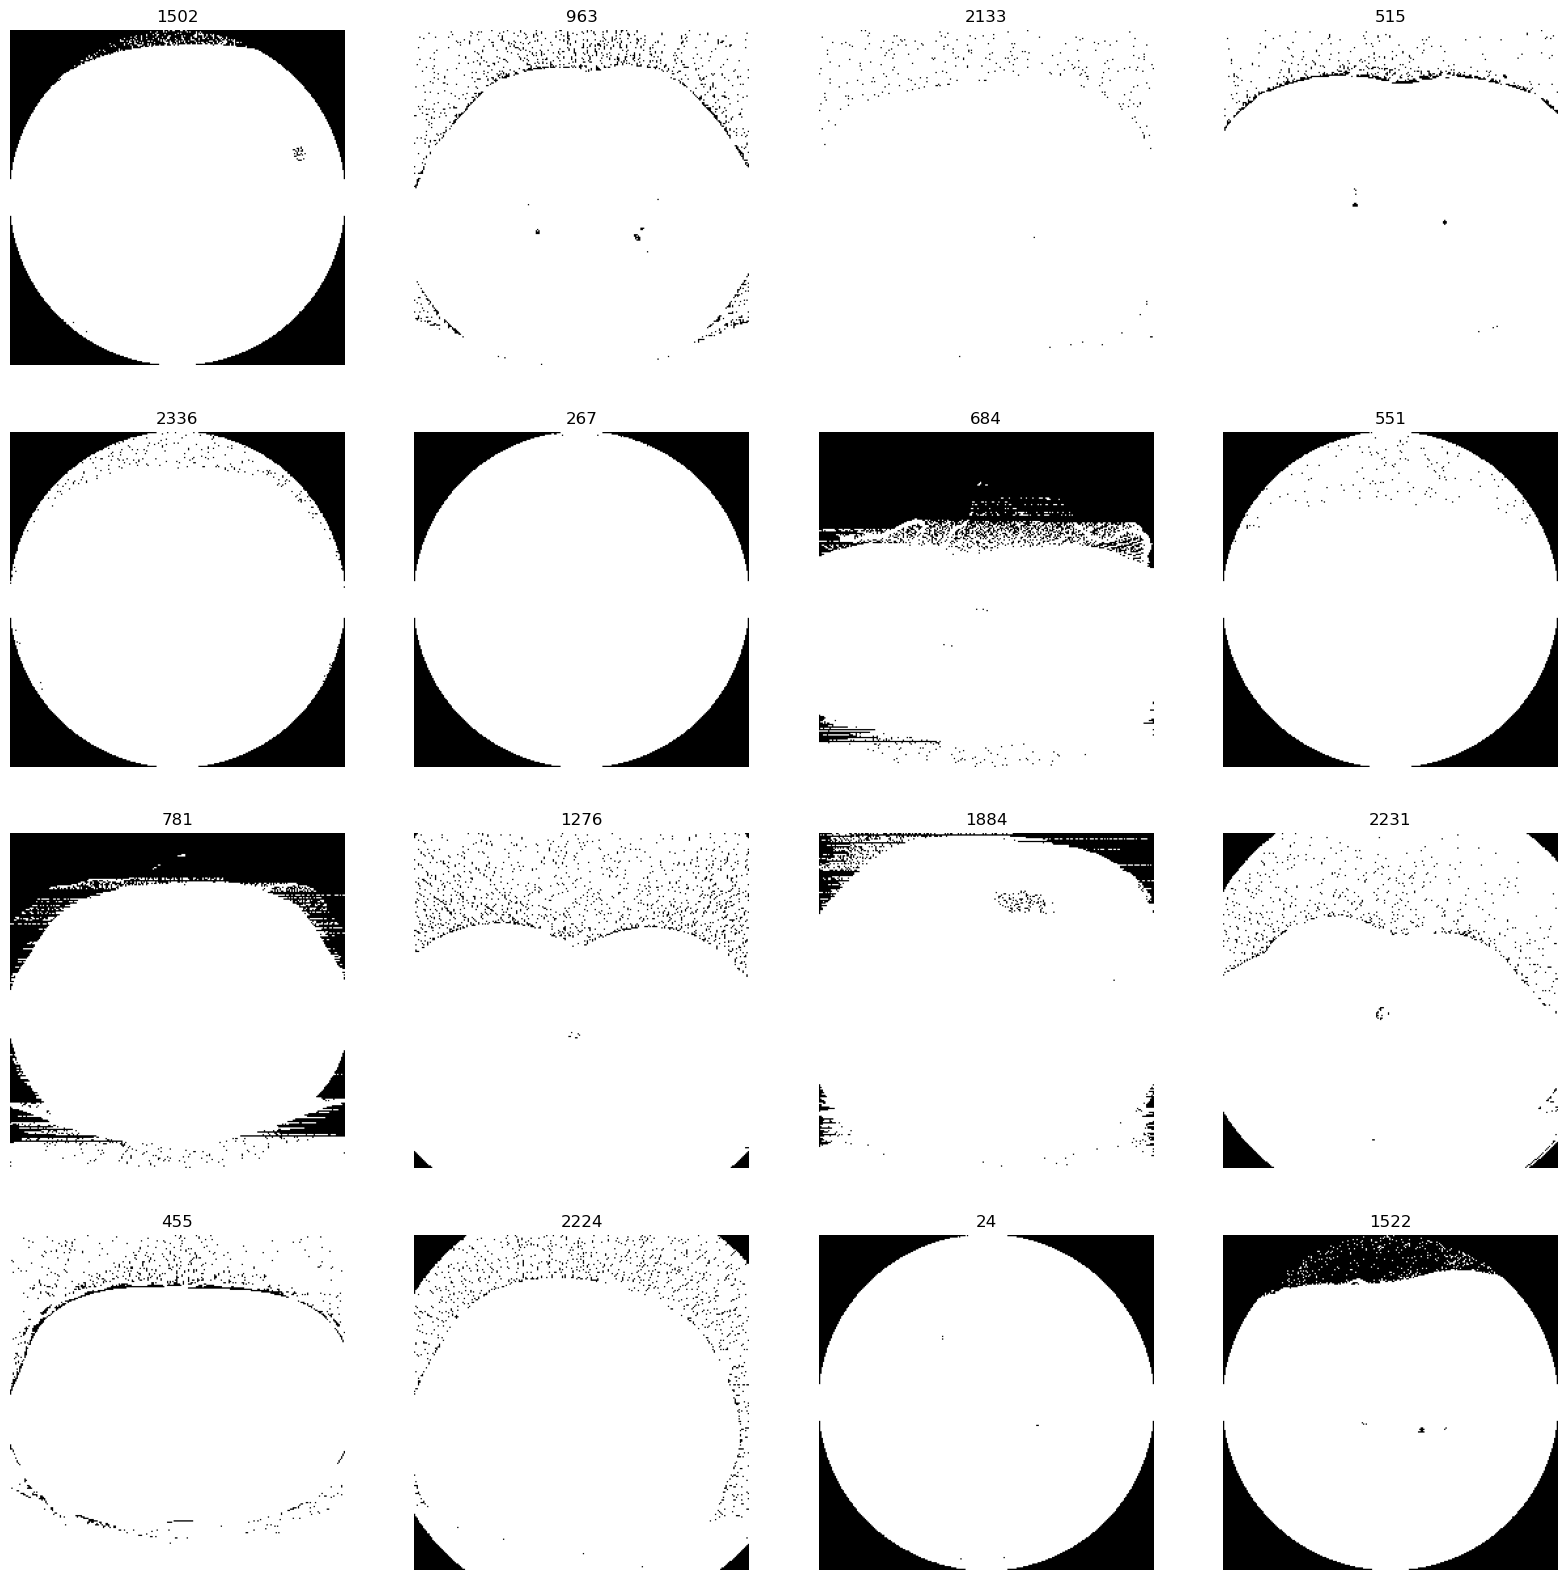

In [5]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

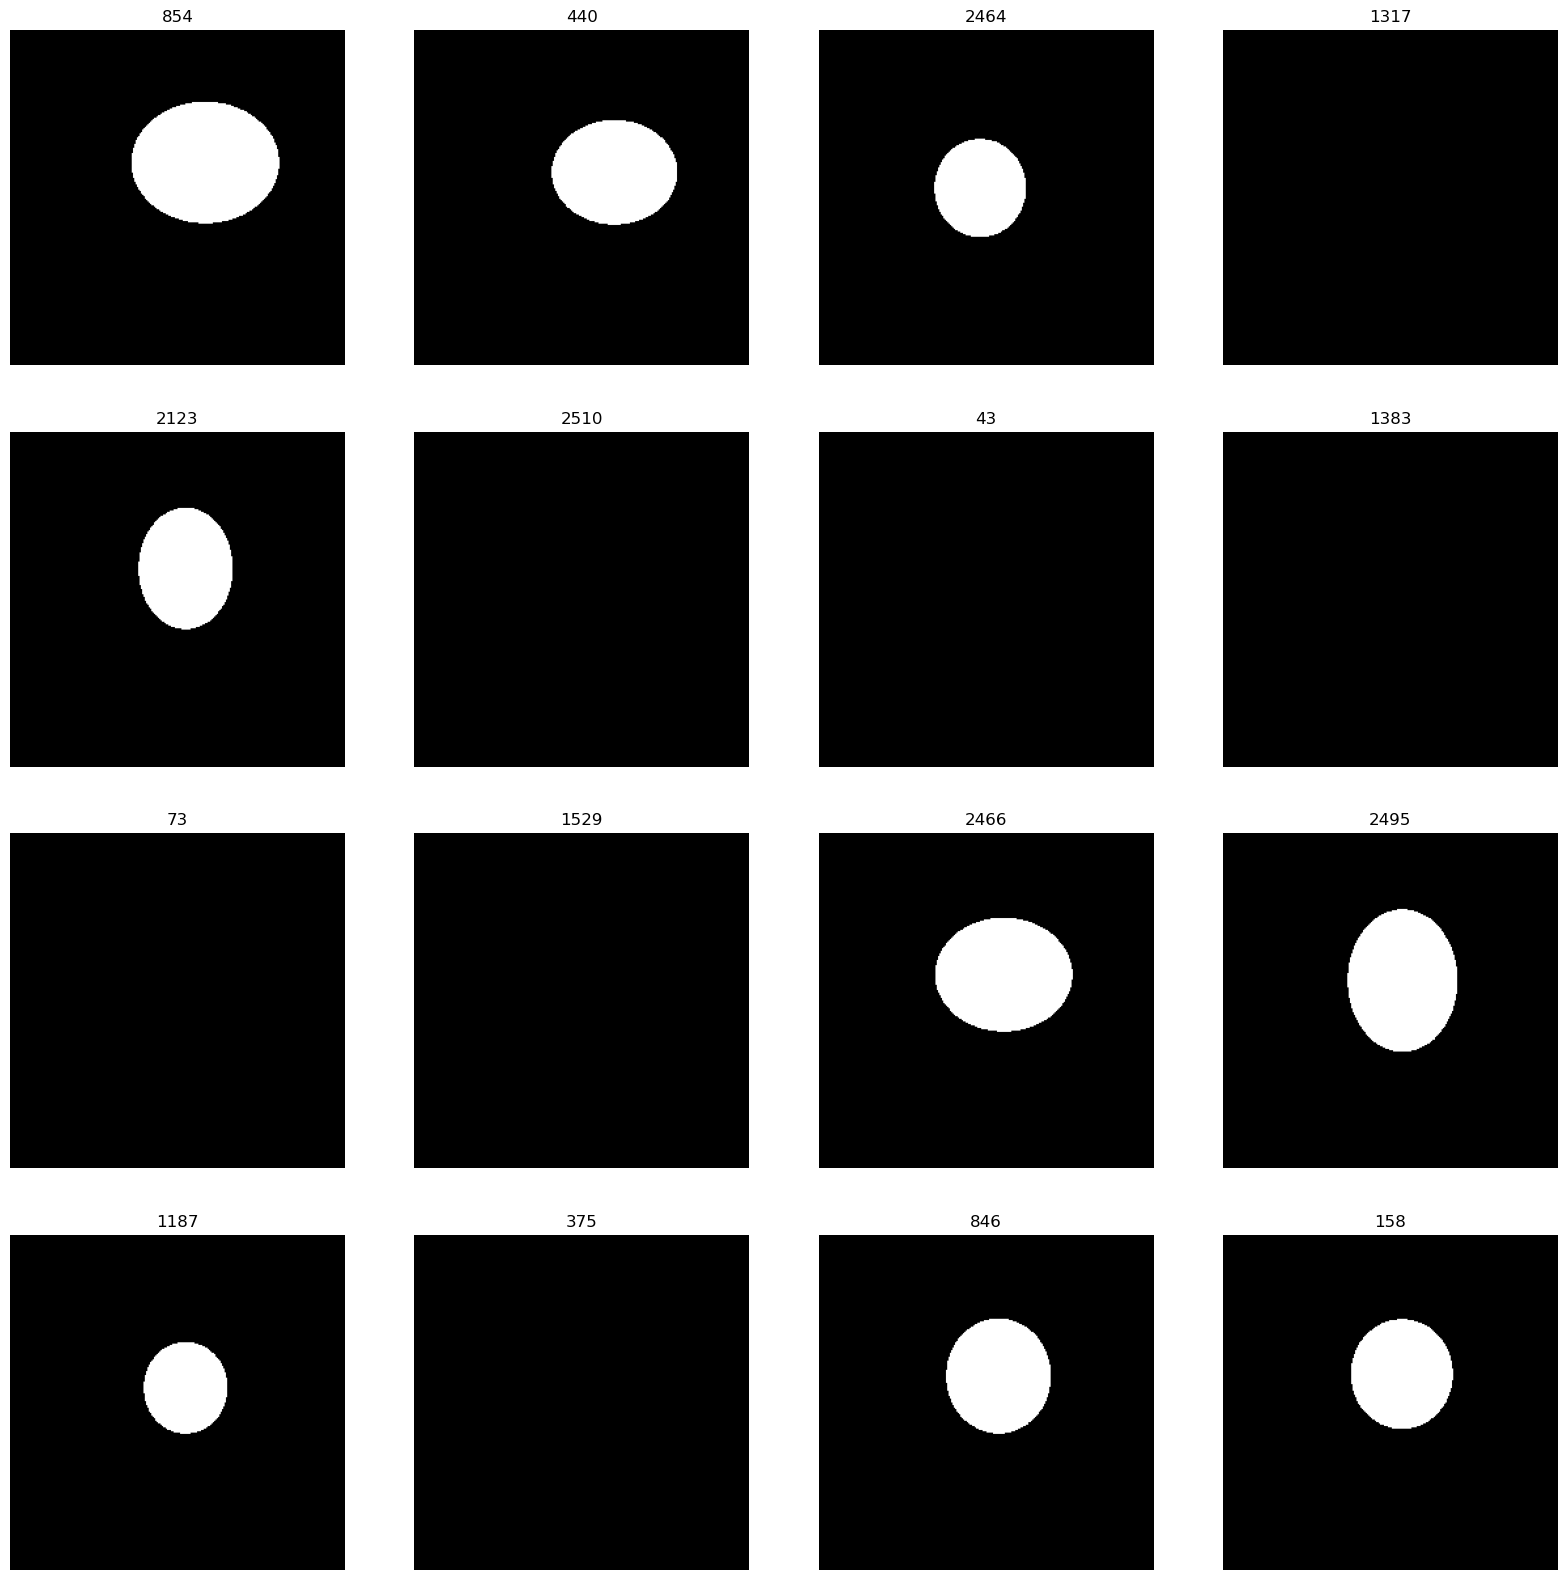

In [6]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [7]:
X_train = X_train/X_train.max()

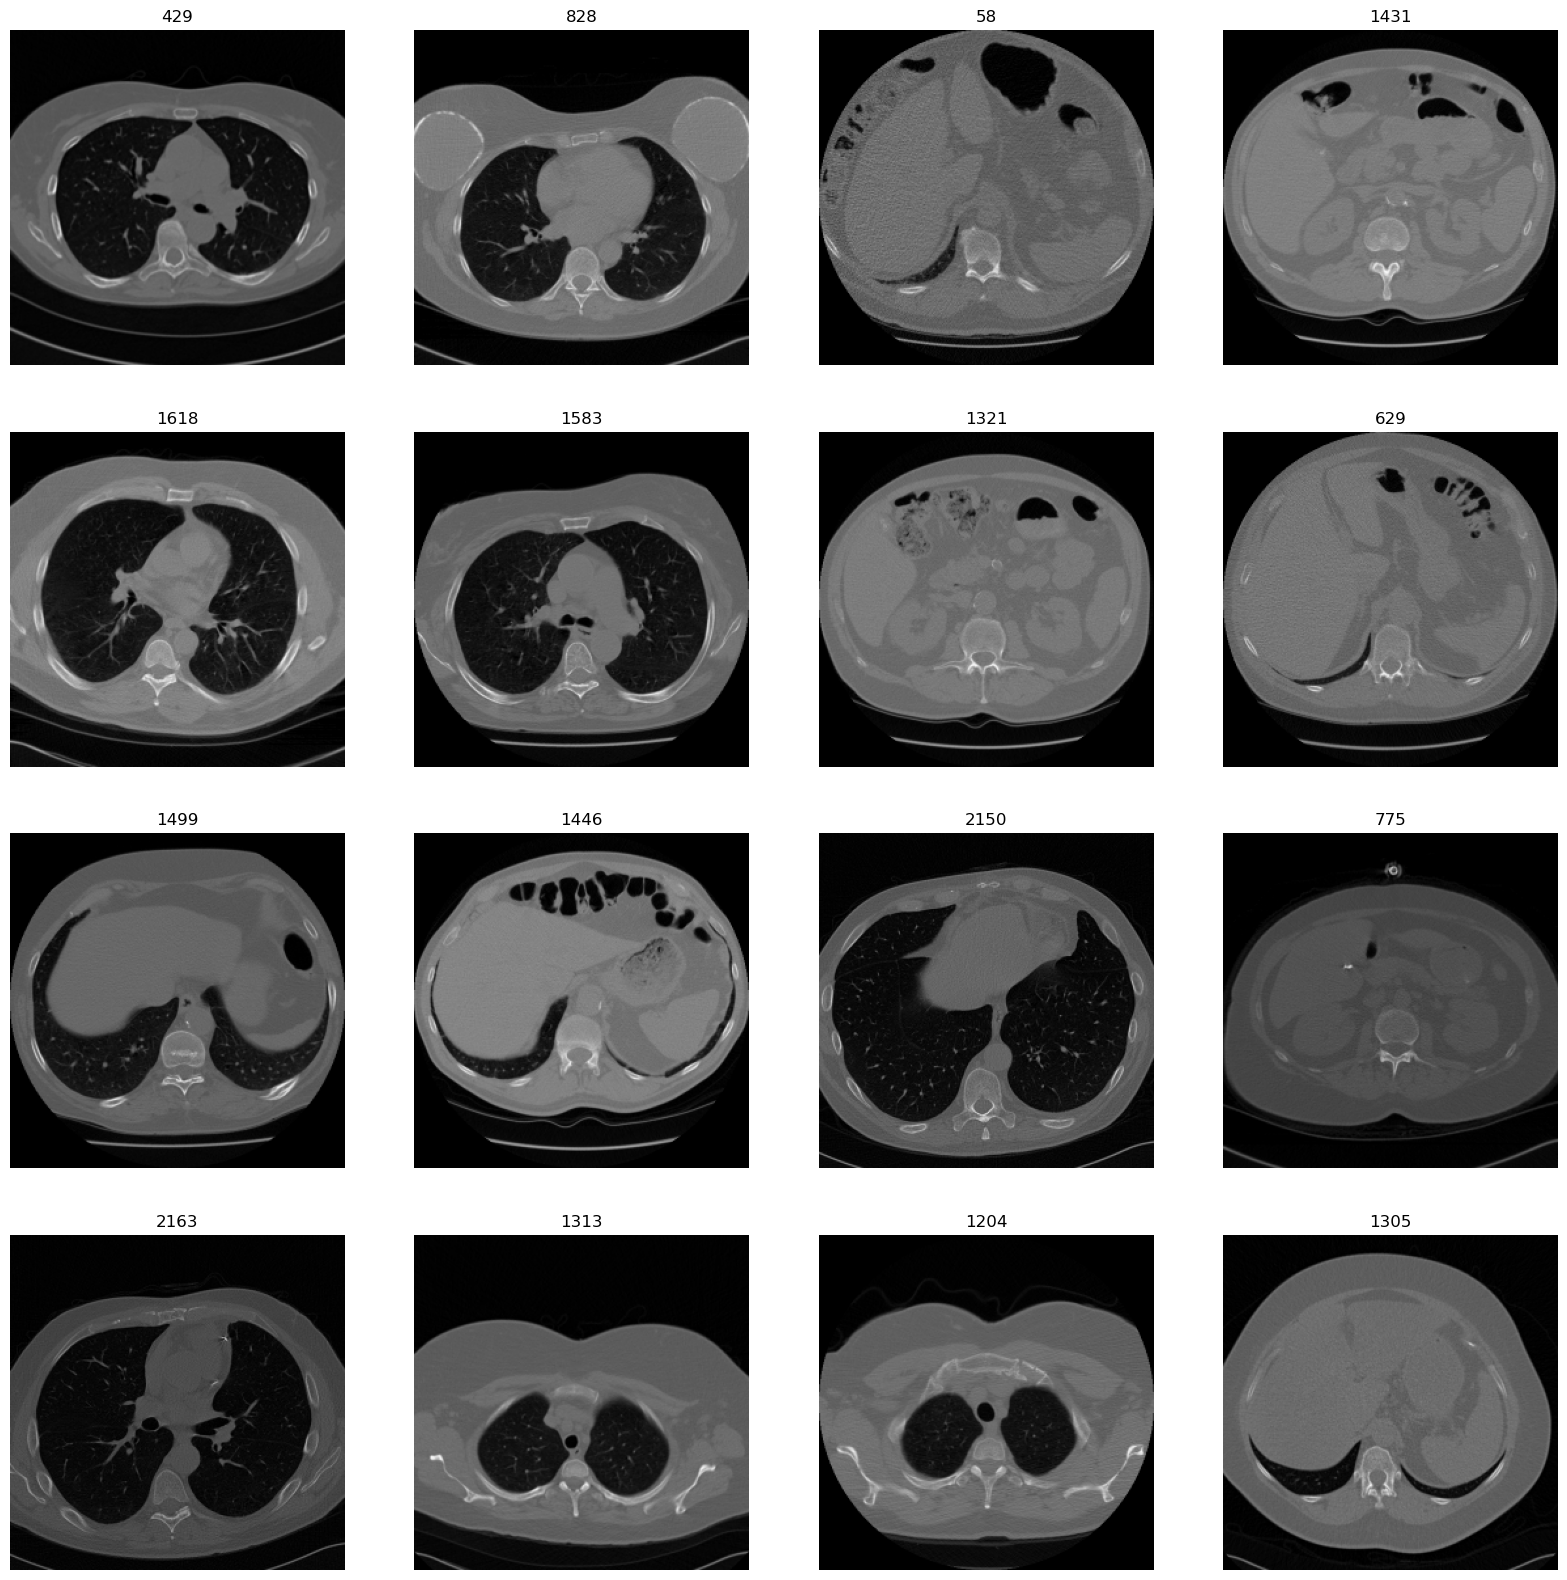

In [8]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [9]:
# plt.imshow(cv2.addWeighted(np.squeeze(X_train[i]), .5, np.squeeze(np.repeat(Y_train[i], 3, axis=-1)), .5, 0), cmap="gray")

## Testing Data images

In [10]:
TEST_PATH ='data/test/'
X_test=[]
for folder in os.listdir(TEST_PATH):
    files=gb.glob(TEST_PATH+folder+'/'+str(os.listdir(TEST_PATH+'/'+folder)[0])+'/*.dcm')
    for file in files :
        ds = dicom.dcmread(file)
        img = ds.pixel_array
        img = cv2.resize(img, (img_height, img_width)) 
        X_test.append(list(img))

In [11]:
X_test=np.array(X_test)

In [12]:
X_test=np.stack((X_test,)*3,axis=-1)
X_test.shape

(832, 256, 256, 3)

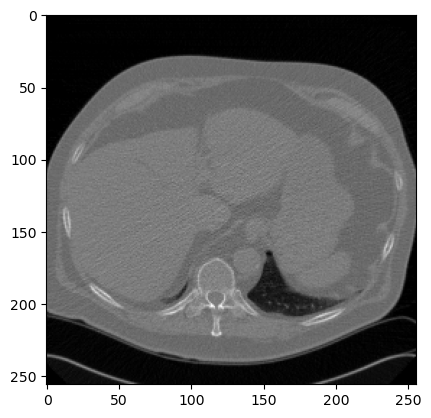

In [13]:
plt.imshow((X_test[259]/X_test[259].max()).astype(np.float32))
# plt.imshow(X_train[0].astype(np.float32))

In [14]:
X_test = X_test/X_test.max()

In [15]:
X_test[0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.01882986, 0.01882986, 0.01882986],
        [0.01479489, 0.01479489, 0.01479489],
        [0.01244116, 0.01244116, 0.01244116]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.0205111 , 0.0205111 , 0.0205111 ],
        [0.00941493, 0.00941493, 0.00941493],
        [0.01008742, 0.01008742, 0.01008742]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.00975118, 0.00975118, 0.00975118],
        [0.0127774 , 0.0127774 , 0.0127774 ],
        [0.00605245, 0.00605245, 0.00605245]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [16]:
X_test=X_test.astype(np.float32)

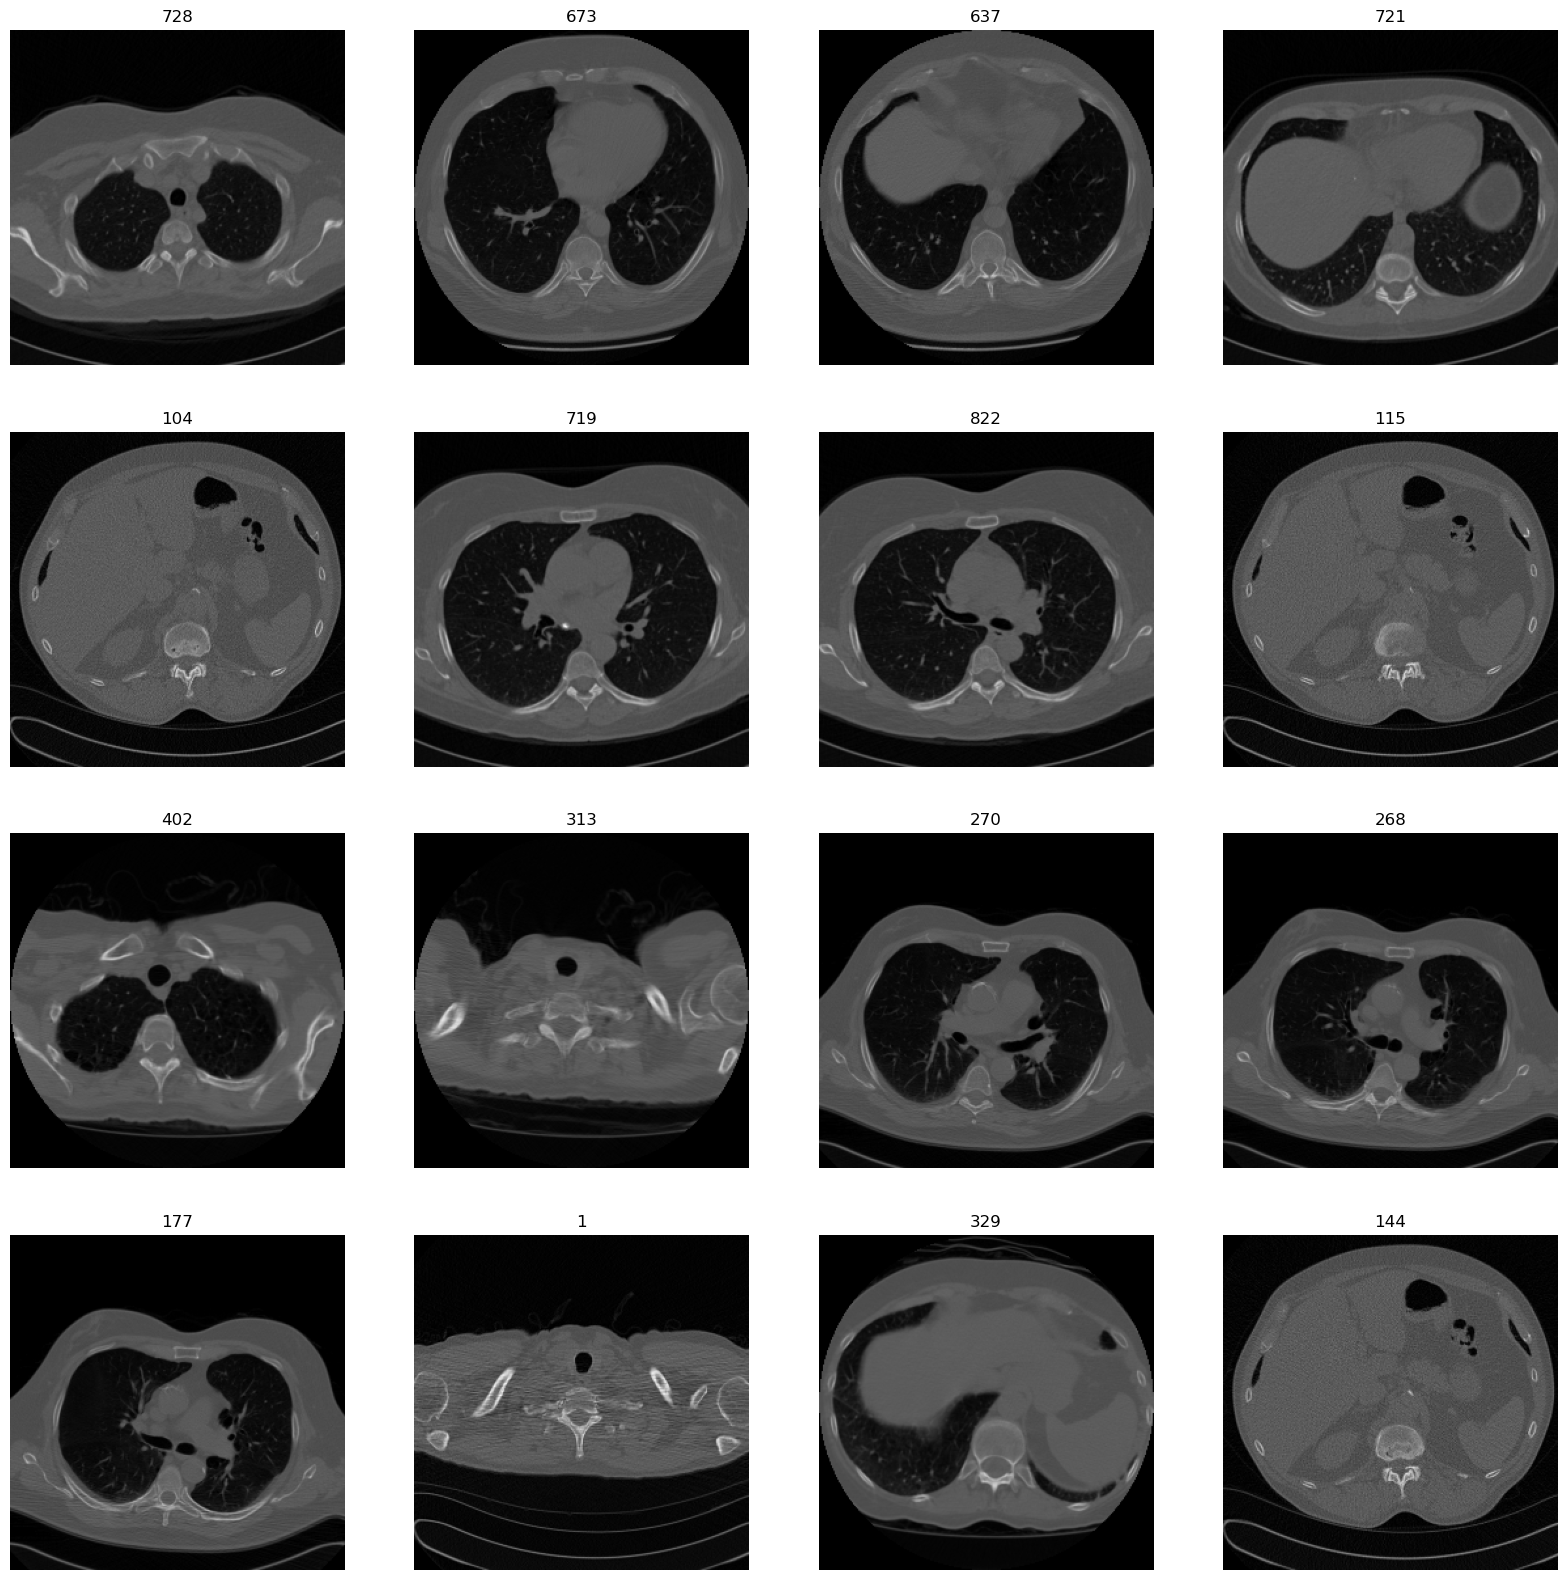

In [17]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    # Image = np.clip(Image, 0, 1)
    plt.imshow(np.clip(X_test[i],0,1))
    plt.axis('off')
    plt.title(i)


# Model Prepration
link to the reffered kaggle notebook: 
- https://www.kaggle.com/code/vuppalaadithyasairam/unet-for-heart-segmentation
- https://www.kaggle.com/code/hossamfakher/ct-heart-segmentation

In [18]:
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb2'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet')

2024-03-25 22:12:21.289245: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 22:12:21.317756: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('segmentation-model.weights.h5',monitor='val_loss',verbose=1,save_weights_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [20]:
from tensorflow.keras.losses import Loss

In [21]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
        union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
        dice = tf.reduce_mean((2. * intersection + self.smooth) / (union + self.smooth), axis=0)
        return 1 - dice

In [23]:
model.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), 
                                                                    tf.keras.metrics.Precision(), 
                                                                    tf.keras.metrics.AUC(),
                                                                    sm.metrics.iou_score,
                                                                    sm.metrics.FScore(threshold=0.7)])

In [24]:
history=model.fit(X_train,Y_train,
                  validation_split=0.1,
                  batch_size=2,
                  steps_per_epoch=len(X_train)//32,
                  epochs=40,
                 callbacks=callback,
                  verbose=1)

2024-03-25 22:13:04.753925: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1791492096 exceeds 10% of free system memory.


Epoch 1/40


2024-03-25 22:13:05.930826: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 597164032 exceeds 10% of free system memory.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - auc: 0.8996 - f1-score: 0.3197 - iou_score: 0.0878 - loss: 0.8502 - precision: 0.1085 - recall: 0.9209
Epoch 1: saving model to segmentation-model.weights.h5


/home/lokeswarlakhineni/miniconda3/envs/dldev/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:97: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: auc,f1-score,iou_score,loss,precision,recall,val_auc,val_f1-score,val_iou_score,val_loss,val_precision,val_recall,learning_rate.
  callback.on_epoch_end(epoch, logs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - auc: 0.9001 - f1-score: 0.3202 - iou_score: 0.0882 - loss: 0.8498 - precision: 0.1090 - recall: 0.9207 - val_auc: 0.6877 - val_f1-score: 0.0688 - val_iou_score: 0.0348 - val_loss: 0.9346 - val_precision: 0.0341 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - auc: 0.9187 - f1-score: 0.6044 - iou_score: 0.3989 - loss: 0.4939 - precision: 0.6119 - recall: 0.8414
Epoch 2: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 74s 933ms/step - auc: 0.9180 - f1-score: 0.6034 - iou_score: 0.3988 - loss: 0.4942 - precision: 0.6109 - recall: 0.8403 - val_auc: 0.6191 - val_f1-score: 0.0702 - val_iou_score: 0.0372 - val_loss: 0.9302 - val_precision: 0.0393 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - auc: 0.8491 - f1-score: 0.3913 - iou_score: 0.3094 - loss: 0.6187 - precision: 0.2961 - recall: 0.7000
Epoch 3: saving model to segmenta

2024-03-25 22:31:28.191104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/lokeswarlakhineni/miniconda3/envs/dldev/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 15: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 492ms/step - auc: 0.9548 - f1-score: 0.5535 - iou_score: 0.5152 - loss: 0.4297 - precision: 0.6263 - recall: 0.8991 - val_auc: 0.9641 - val_f1-score: 0.8093 - val_iou_score: 0.5412 - val_loss: 0.4114 - val_precision: 0.8241 - val_recall: 0.9107 - learning_rate: 0.0010
Epoch 16/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - auc: 0.9513 - f1-score: 0.5471 - iou_score: 0.5044 - loss: 0.4536 - precision: 0.6436 - recall: 0.9021
Epoch 16: saving model to segmentation-model.weights.h5
79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 924ms/step - auc: 0.9515 - f1-score: 0.5470 - iou_score: 0.5044 - loss: 0.4537 - precision: 0.6435 - recall: 0.9023 - val_auc: 0.9845 - val_f1-score: 0.7803 - val_iou_score: 0.5166 - val_loss: 0.4264 - val_precision: 0.7266 - val_recall: 0.9709 - learning_rate: 0.0010
Epoch 17/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - auc: 0.9016 - f1-score: 0.4534 - iou_score: 0.4145 - loss: 0.5469 - precis

In [ ]:
y_pred=model.predict(X_train)

In [ ]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

In [ ]:
model.load_weights('./segmentation-model.weights.h5')

In [ ]:
def plot_performance(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_performance(history)

In [ ]:
t = random.randint(1,300)
plt.imshow(y_pred_p[0])

In [ ]:

plt.figure(figsize=(15,15))
plt.axis('Off')
# t = random.randint(1,300)
test_image = X_test[t, :, :, 0]
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title('Input Image', fontsize=14)
plt.axis('off')


test_mask = y_pred_p[t, :, :, 0]
plt.subplot(1,3,3)
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

In [ ]:
test_image = X_test[t, :, :, 0]
test_mask = y_pred_p[t, :, :, 0]

In [ ]:
ll = list(np.random.randint(0,len(X_test),16))

In [ ]:
train_preds = model.predict

In [ ]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i, :, :, 0],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [ ]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(y_pred[i, :, :, 0],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [ ]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(ll) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [ ]:
model.save("model_4.keras")

In [ ]:
model.summary()

In [ ]:
model.save_weights('eff-unet.weights.h5')

In [ ]:
def create_model():
    sm.set_framework('tf.keras')
    sm.framework()
    BACKBONE = 'efficientnetb2'

    preprocess_input = get_preprocessing(BACKBONE)
    modeel = Unet(BACKBONE, encoder_weights='imagenet')
    modeel.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), 
                                                                    tf.keras.metrics.Precision(), 
                                                                    tf.keras.metrics.AUC(),
                                                                    sm.metrics.iou_score,
                                                                    sm.metrics.FScore(threshold=0.5)])
    return modeel
moodel = create_model()

In [ ]:
moodel = moodel.load_weights('./segmentation-model.weights.h5')

In [ ]:
moodel.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), 
                                                                    tf.keras.metrics.Precision(), 
                                                                    tf.keras.metrics.AUC(),
                                                                    sm.metrics.iou_score,
                                                                    sm.metrics.FScore(threshold=0.5)])

In [ ]:
y_pred=moodel.evaluate(X_train,Y_train)